# Fuel Efficiency Prediction
#### CHAPTER 05: _Global Model-agnostic Interpretation Methods_
##### From **[Interpretable Machine Learning with Python](https://www.packtpub.com/product/interpretable-machine-learning-with-python/9781800203907)** by Serg Masís, published by Packt

## The Preparations

### Installing the Libraries

In [1]:
# !pip install git+https://github.com/tensorflow/docs
# !pip install --upgrade shap
# !pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/tensorflow/docs to /private/var/folders/cr/dlw4zhlj7ld9t1grnb2q9hvw0000gn/T/pip-req-build-vms_qt5g
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /private/var/folders/cr/dlw4zhlj7ld9t1grnb2q9hvw0000gn/T/pip-req-build-vms_qt5g
  Resolved https://github.com/tensorflow/docs to commit b64768499123da8b2253a534277d62e20de3ec73
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.2.5.73858-py3-none-any.whl size=182443 sha256=00afb5f9efc037718e35391504cd2db4fc319208fba7fb6b3fc307c12aaa756d
  Stored in directory: /private/var/folders/cr/dlw4zhlj7ld9t1grnb2q9hvw0000gn/T/pip-ephem-wheel-cache-dhcxpt1k/wheels/34/53/89/3db54cf97ce0f0261aaab3fdc12a847ea0879d34edf373e2c5
Successfully built tensorflow-docs
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.1/452.1 kB 2.2 MB/s eta 0:00:00a 0:00:01
  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /priva

### Loading the Libraries

In [3]:
# !pip install rulefit

  Preparing metadata (setup.py) ... done
  Created wheel for rulefit: filename=rulefit-0.3.1-py3-none-any.whl size=7799 sha256=a04f516d4a25b8d05f93ee5e2d659af6981e9157cc56bb58912878c9ace41a27
  Stored in directory: /Users/fulin/Library/Caches/pip/wheels/0c/b7/1f/c3c2e1d101b3e6095e55ae4e727dd6cf413f0e800ab38d038e
Successfully built rulefit


In [6]:
import math
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics, tree
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import xgboost as xgb
from rulefit import RuleFit
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from alepython import ale_plot

In [7]:
print(tf.__version__)

2.15.0


### Understanding and Preparing the Data

In [3]:
fueleconomy_df = pd.read_csv("./data/vehicles.csv", delimiter=',')

Columns (70,71,72,73,74,76,79) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
fueleconomy_df.columns

Index(['barrels08', 'barrelsA08', 'charge120', 'charge240', 'city08',
       'city08U', 'cityA08', 'cityA08U', 'cityCD', 'cityE', 'cityUF', 'co2',
       'co2A', 'co2TailpipeAGpm', 'co2TailpipeGpm', 'comb08', 'comb08U',
       'combA08', 'combA08U', 'combE', 'combinedCD', 'combinedUF', 'cylinders',
       'displ', 'drive', 'engId', 'eng_dscr', 'feScore', 'fuelCost08',
       'fuelCostA08', 'fuelType', 'fuelType1', 'ghgScore', 'ghgScoreA',
       'highway08', 'highway08U', 'highwayA08', 'highwayA08U', 'highwayCD',
       'highwayE', 'highwayUF', 'hlv', 'hpv', 'id', 'lv2', 'lv4', 'make',
       'model', 'mpgData', 'phevBlended', 'pv2', 'pv4', 'range', 'rangeCity',
       'rangeCityA', 'rangeHwy', 'rangeHwyA', 'trany', 'UCity', 'UCityA',
       'UHighway', 'UHighwayA', 'VClass', 'year', 'youSaveSpend', 'guzzler',
       'trans_dscr', 'tCharger', 'sCharger', 'atvType', 'fuelType2', 'rangeA',
       'evMotor', 'mfrCode', 'c240Dscr', 'charge240b', 'c240bDscr',
       'createdOn', 'modifiedOn

In [5]:
fueleconomy_df.shape

(46024, 83)

In [6]:
columns = ['year', 'fuelType', 'cylinders', 'displ', 'eng_dscr', 'phevBlended', 'atvType', 'co2TailpipeGpm', 'co2', 'ghgScore', 'drive', 'trany', 'trans_dscr', 'VClass', 'pv4', 'lv4', 'lv2', 'pv2', 'hlv', 'hpv','startStop','tCharger','comb08']

In [7]:
print(len(columns))
fueleconomy_df = fueleconomy_df[columns]
len(fueleconomy_df.columns)

23


23

In [8]:
fueleconomy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46024 entries, 0 to 46023
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            46024 non-null  int64  
 1   fuelType        46024 non-null  object 
 2   cylinders       45537 non-null  float64
 3   displ           45539 non-null  float64
 4   eng_dscr        28976 non-null  object 
 5   phevBlended     46024 non-null  bool   
 6   atvType         4678 non-null   object 
 7   co2TailpipeGpm  46024 non-null  float64
 8   co2             46024 non-null  int64  
 9   ghgScore        46024 non-null  int64  
 10  drive           44838 non-null  object 
 11  trany           46013 non-null  object 
 12  trans_dscr      15044 non-null  object 
 13  VClass          46024 non-null  object 
 14  pv4             46024 non-null  int64  
 15  lv4             46024 non-null  int64  
 16  lv2             46024 non-null  int64  
 17  pv2             46024 non-null 

In [9]:
for c in fueleconomy_df.columns:
    if fueleconomy_df[c].isnull().sum()>0:
        print(c, fueleconomy_df[c].isnull().sum())

cylinders 487
displ 485
eng_dscr 17048
atvType 41346
drive 1186
trany 11
trans_dscr 30980
startStop 31689
tCharger 36449


In [10]:
fueleconomy_df.loc[fueleconomy_df.atvType.isnull(), 'atvType'] = 'Other'
fueleconomy_df.loc[fueleconomy_df.trans_dscr.isnull(), 'trans_dscr'] = 'Other'
fueleconomy_df.loc[fueleconomy_df.eng_dscr.isnull(), 'eng_dscr'] = 'Other'
fueleconomy_df.tCharger = fueleconomy_df.tCharger.apply(lambda x: 1 if x=='yes' else 0)
fueleconomy_df.startStop = fueleconomy_df.startStop.apply(lambda x: 1 if x=='yes' else 0)

In [11]:
fueleconomy_df.dropna(inplace=True)
fueleconomy_df.reset_index(inplace=True, drop=True)

In [12]:
fueleconomy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44357 entries, 0 to 44356
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            44357 non-null  int64  
 1   fuelType        44357 non-null  object 
 2   cylinders       44357 non-null  float64
 3   displ           44357 non-null  float64
 4   eng_dscr        44357 non-null  object 
 5   phevBlended     44357 non-null  bool   
 6   atvType         44357 non-null  object 
 7   co2TailpipeGpm  44357 non-null  float64
 8   co2             44357 non-null  int64  
 9   ghgScore        44357 non-null  int64  
 10  drive           44357 non-null  object 
 11  trany           44357 non-null  object 
 12  trans_dscr      44357 non-null  object 
 13  VClass          44357 non-null  object 
 14  pv4             44357 non-null  int64  
 15  lv4             44357 non-null  int64  
 16  lv2             44357 non-null  int64  
 17  pv2             44357 non-null 

In [13]:
for c in [ 'fuelType', 'eng_dscr', 'atvType', 'drive', 'trany', 'trans_dscr', 'VClass']:
    print(c, len(set(fueleconomy_df[c])))

fuelType 13
eng_dscr 585
atvType 8
drive 7
trany 38
trans_dscr 53
VClass 34


In [16]:
# getting all engine_descriptions in the dataset
# this code needs optimization
set_engine_descriptors = []
i=0
for d in fueleconomy_df.eng_dscr:
    if ',' in d:
        descriptors = d.replace('(', '').replace(')','').replace(' ', ',').split(',')
    else:
        descriptors = d.replace('(', '').replace(')','').replace(' ', ',').split(',')
#     if 'F' in descriptors:
#         print(d, i, descriptors)
    i+=1
    for dd in descriptors:
        if dd not in set_engine_descriptors and dd!='':
            set_engine_descriptors.append(dd)
# creating an empty column for all the engine description codes
for c in set_engine_descriptors:
    fueleconomy_df['eng_dscr_'+c] = [1 if c in fueleconomy_df.eng_dscr[i] else 0 for i in range(len(fueleconomy_df))]

In [26]:
# getting all transmission descriptions in the dataset
set_transmission_descriptors = []
i=0
for d in fueleconomy_df.trans_dscr:
    descriptors = d.split(' ')
    i+=1
    for dd in descriptors:
        if dd not in set_transmission_descriptors and dd!='':
            set_transmission_descriptors.append(dd)
# creating an empty column for all the engine description codes
for c in set_transmission_descriptors:
    fueleconomy_df['trans_dscr_'+c] = [1 if c in fueleconomy_df.trans_dscr[i] else 0 for i in range(len(fueleconomy_df))]

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [30]:
fueleconomy_df = pd.get_dummies(fueleconomy_df, columns = [ 'fuelType', 'atvType', 'drive', 'trany', 'VClass'])

In [31]:
fueleconomy_df.shape

(44357, 604)

#### Data Preparation

In [32]:
rand = 9
y = fueleconomy_df['comb08']
X = fueleconomy_df.drop(['comb08', 'eng_dscr', 'trans_dscr'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                    test_size=0.15, random_state=rand)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,\
                                    test_size=0.2, random_state=rand)

#### Modeling and Performance Evaluation for XGBoost

In [44]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [45]:
fitted_xgb_model = xgb.XGBRegressor(max_depth=7, learning_rate=0.6,\
                    n_jobs=4, objective='reg:squarederror',\
                    random_state=rand, n_estimators=50).\
                    fit(X_train, y_train,\
                    eval_set=[(X_train, y_train),(X_val, y_val)],\
                    eval_metric='rmse')

[0]	validation_0-rmse:8.33641	validation_1-rmse:8.33898
[1]	validation_0-rmse:3.36568	validation_1-rmse:3.37261
[2]	validation_0-rmse:1.38125	validation_1-rmse:1.39314
[3]	validation_0-rmse:0.60418	validation_1-rmse:0.61738
[4]	validation_0-rmse:0.32020	validation_1-rmse:0.34641
[5]	validation_0-rmse:0.23542	validation_1-rmse:0.26607
[6]	validation_0-rmse:0.20006	validation_1-rmse:0.24854
[7]	validation_0-rmse:0.17916	validation_1-rmse:0.22529
[8]	validation_0-rmse:0.16506	validation_1-rmse:0.21731
[9]	validation_0-rmse:0.15821	validation_1-rmse:0.21212
[10]	validation_0-rmse:0.15368	validation_1-rmse:0.21335
[11]	validation_0-rmse:0.14791	validation_1-rmse:0.20996
[12]	validation_0-rmse:0.14211	validation_1-rmse:0.20830
[13]	validation_0-rmse:0.13909	validation_1-rmse:0.20777
[14]	validation_0-rmse:0.13446	validation_1-rmse:0.20548
[15]	validation_0-rmse:0.13284	validation_1-rmse:0.20572
[16]	validation_0-rmse:0.12947	validation_1-rmse:0.20375
[17]	validation_0-rmse:0.12839	validation

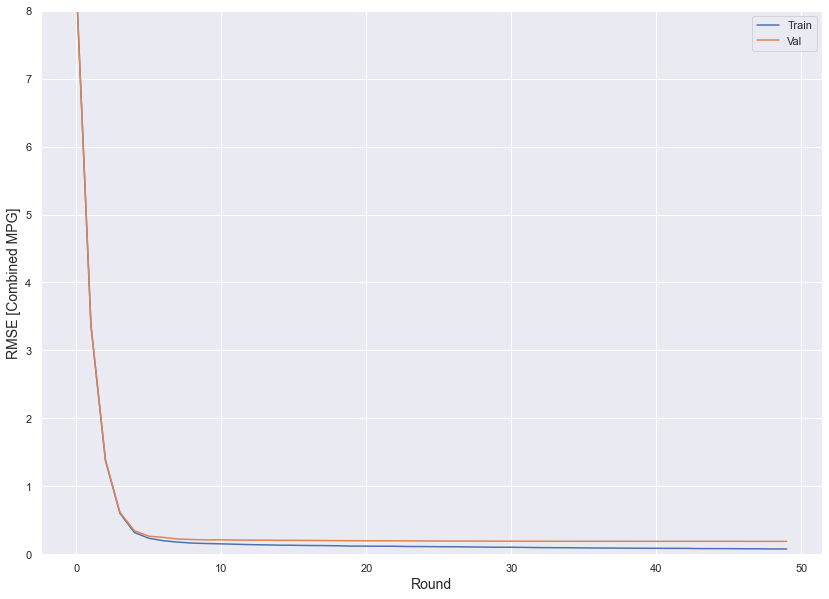

In [47]:
plt.figure(figsize=(14, 10))
plt.rcParams.update({'font.size': 14})
plt.plot(fitted_xgb_model.evals_result()['validation_0']['rmse'])
plt.plot(fitted_xgb_model.evals_result()['validation_1']['rmse'])
plt.ylabel('RMSE [Combined MPG]', fontsize=14)
plt.ylim([0, 8])
plt.xlabel('Round', fontsize=14)
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [48]:
y_train_xgb_pred = fitted_xgb_model.predict(X_train)
y_test_xgb_pred = fitted_xgb_model.predict(X_test)
RMSE_xgb_train = math.sqrt(\
                    metrics.mean_squared_error(y_train,\
                                               y_train_xgb_pred))
RMSE_xgb_test = math.sqrt(\
                    metrics.mean_squared_error(y_test,
                                               y_test_xgb_pred))
R2_xgb_test = metrics.r2_score(y_test, y_test_xgb_pred)
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
                    (RMSE_xgb_train, RMSE_xgb_test, R2_xgb_test))

RMSE_train: 0.0785	RMSE_test: 0.2383	r2: 0.9981


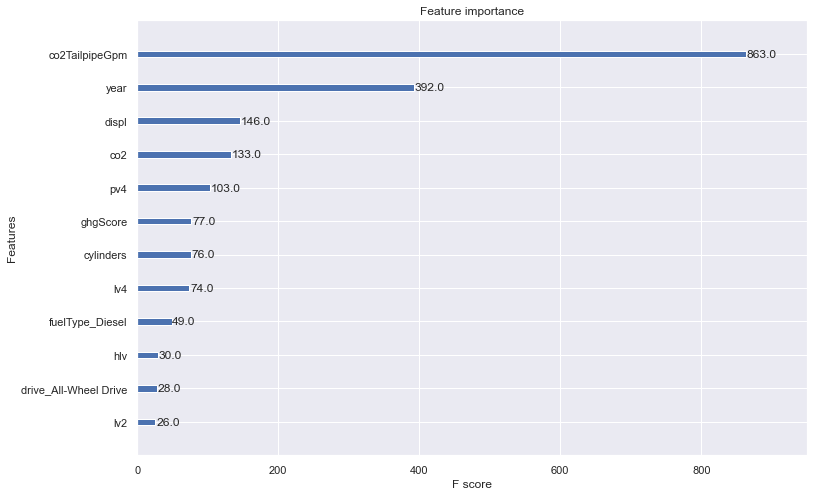

In [49]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(fitted_xgb_model, max_num_features=12, ax=ax,\
                    importance_type="weight")
plt.show()

## Interpreting SHAP Summary and Dependence Plots

### Initializing Explainers
The TreeExplainer only requires the fitted tree-based model. <br>
Once, the explainer is initialized, we can compute the SHAP values.

In [50]:
shap_xgb_explainer = shap.TreeExplainer(fitted_xgb_model)

### Computing SHAP Values
For the XGBoost model, we will compute the SHAP values on both the train & test sets. <br>
Understanding what the model finds in seen and in previously unseen data allows us to test the consistency of our model. <br>
The output shape of ```shap_xgb_values_train``` and ```shap_xgb_values_test``` should be the same as the trrain & test datasets' shapes; there should be one SHAP value for every feature. 

In [56]:
shap_xgb_values_train = shap_xgb_explainer.shap_values(X_train)
print(shap_xgb_values_train.shape)
shap_xgb_values_test = shap_xgb_explainer.shap_values(X_test)
print(shap_xgb_values_test.shape)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(30162, 601)
(6654, 601)


### Generating SHAP Summary Plots

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


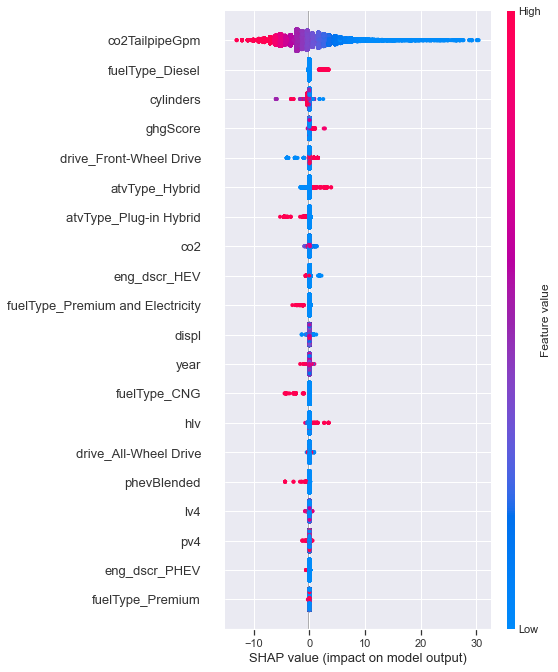

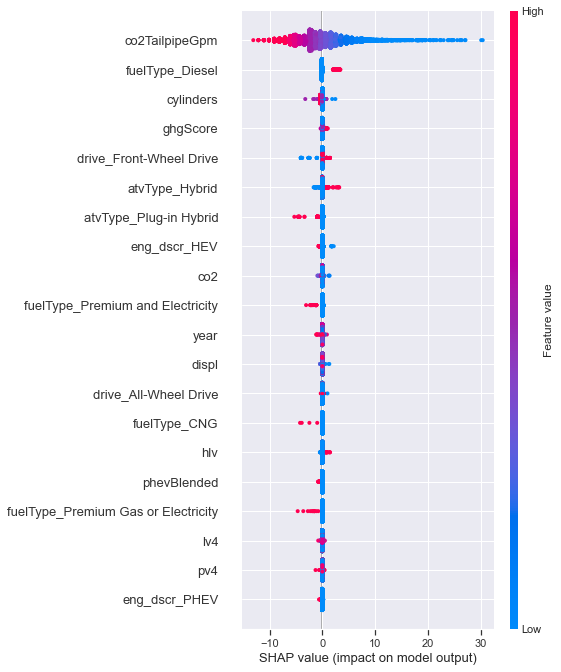

In [58]:
shap.summary_plot(shap_xgb_values_train, X_train, plot_type="dot")
shap.summary_plot(shap_xgb_values_test, X_test, plot_type="dot")

In [93]:
# sns.distplot(fueleconomy_df['cylinders'])

#### From ``` shap_xgb_values_train```
- feature co2TailpipeGpm: high feature values (i.e., co2TailpipeGpm>500) correlate negatively & low feature values ) (i.e. co2TailpipeGpm<300correlate positively with the target comb08 (or fuel efficiency measured by Miles Per Gallon);  co2TailpipeGpm is a pollution feature, the higher its value the lowest the fuel efficiency is.
- feature fuelType_Diesel: high values (i.e., here the presence of the binary feature fuelType_Diesel) correlate positively --> this also makes sense, because diesel cars are more fuel efficient 
- feature cylinders: high feature values (i.e., cylindrs>8) correlate negatively & low feature values (i.e., cylinders<4) correlate positively; this makes sense, because the higher the number of cylinders in a car, the more fuel it needs to travel the same distance, --> the less fuel-efficient it is.
- feature ghgScore: high feature values correlate positively; the higher the greenhouse gas emission estimates, the more fuel efficient cars
- feature drive_Front-Wheel Drive: low feature values (absence of front wheel drive) correlate negatively while high feature values (presence of front wheel drive) correlate positively --> the presence of a front wheel axel drive makes the car more fuel efficient (a higher comb08)
- atvType_Hybrid (alternative fuel type used in the engine, here Hybrid): same like feature drive_Front-Wheel Drive, if a car is Hybrid, it is more fuel efficient
- atvType_Plug-in Hybrid: high feature values correlate negatively; if a car can be fueled by electricity & fuel, it seems to make it less fuel efficient

#### From ``` shap_xgb_values_test```
- feature co2TailpipeGpm: high feature values (i.e., co2TailpipeGpm>500) correlate negatively & low feature values ) (i.e. co2TailpipeGpm<300correlate positively with the target comb08 (or fuel efficiency measured by Miles Per Gallon);  co2TailpipeGpm is a pollution feature, the higher its value the lowest the fuel efficiency is. 
- feature fuelType_Diesel: high values (i.e., here the presence of the binary feature fuelType_Diesel) correlate positively --> this also makes sense, because diesel cars are more fuel efficient 
- feature cylinders: middle feature values (i.e., 4<cylindrs<8) correlate negatively & low feature values (i.e., cylinders<4) correlate positively; this makes sense, because the higher the number of cylinders in a car, the more fuel it needs to travel the same distance, --> the less fuel-efficient it is.
- feature ghgScore: high feature values correlate positively; the higher the greenhouse gas emission estimates, the more fuel efficient cars
- feature drive_Front-Wheel Drive: low feature values (absence of front wheel drive) correlate negatively while high feature values (presence of front wheel drive) correlate positively --> the presence of a front wheel axel drive makes the car more fuel efficient (a higher comb08)
- atvType_Hybrid (alternative fuel type used in the engine, here Hybrid): same like feature drive_Front-Wheel Drive, if a car is Hybrid, it is more fuel efficient
- atvType_Plug-in Hybrid: high feature values correlate negatively; if a car can be fueled by electricity & fuel, it seems *to make it less fuel efficient

### Understanding Interactions

Feature interactions in black-box models can be very complex. <br>
For a model with 601 features, there are $600\times601= 360,600$ bivariate interactions. <br>
However, the vast majority of the average impact on the model output lies in the first feature co2TailpipeGpm, then far behind it, comes the other top 6 features; the summary bar plot shows this. <br>
 It is very likely that we will find the most salient interactions among this top tier of features.

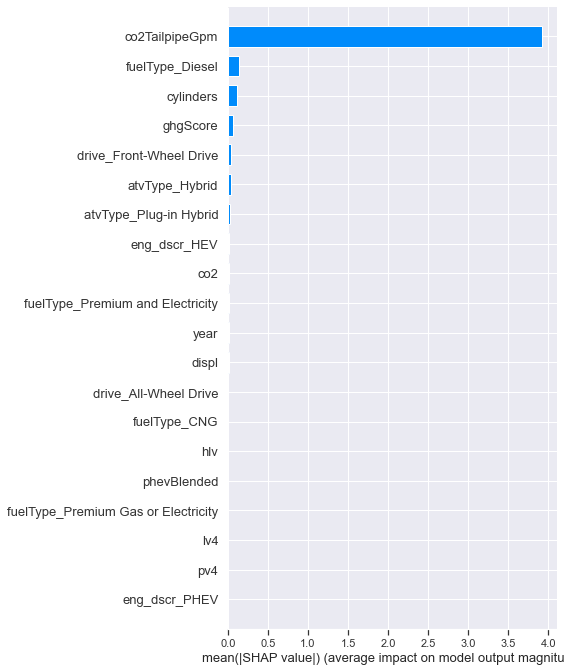

In [118]:
# shap.summary_plot(shap_xgb_values_train, X_train, plot_type="bar")
shap.summary_plot(shap_xgb_values_test, X_test, plot_type="bar")

In [119]:
index_of_column = X_test.columns.tolist().index('co2TailpipeGpm')
print('the mean shap value for the feature co2TailpipeGpm is:', abs(shap_xgb_values_test[:,index_of_column]).mean(),
     '\n This value 3.91 is shown in the bar plot of SHAP for the feature co2TailpipeGpm.')

the mean shap value for the feature co2TailpipeGpm is: 3.9142966 
 This value 3.91 is shown in the bar plot of SHAP for the feature co2TailpipeGpm.


In [113]:
top_features_l = ['comb08'] + ['co2TailpipeGpm', 'fuelType_Diesel', 'cylinders', 'ghgScore', 'drive_Front-Wheel Drive', 'atvType_Hybrid', 'atvType_Plug-in Hybrid']
top_df = fueleconomy_df.loc[X_train.index, top_features_l]

#### Spearman correlation
Here, we are computing the Spearman correlation coefficients of the top features. <br>
Spearman correlation measures the monotonicity between 2 features, even if it is non-linear. <br>
Its value ranges between -1 and 1, indicating both the strength & direction of the relationship. <br>
**NB:** any non-linear non-monotonic relationship between 2 features is not captured by this method. <br>
From ```stats.spearmanr```, we can also extract the p-values of the hypothesis test to validate the correlation. <br>
For binary varables, we will use the ```pointbiserialr```correlation, whcih is the equivalent of spearman for binary variables.

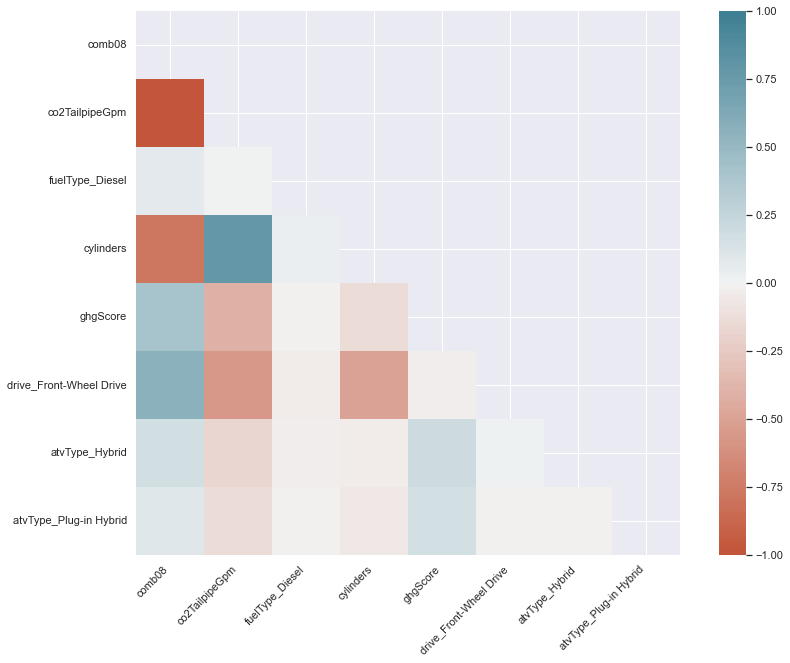

In [120]:
corrs = stats.spearmanr(top_df).correlation
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(
    corrs, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    xticklabels=top_df.columns,
    yticklabels=top_df.columns,
    mask=mask,
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

In [125]:
print('spearman\tco2TailpipeGpm→comb08\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.co2TailpipeGpm.values, top_df.comb08.values)))
print('point-biserial\tfuelType_Diesel→comb08\tcorr: %.3f\tp-val: %.4f' % 
      (stats.pointbiserialr(top_df.fuelType_Diesel.values, top_df.comb08.values)))
print('spearman\tcylinders→comb08\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.cylinders.values, top_df.comb08.values)))
print('spearman\tghgScore→comb08\t\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(top_df.ghgScore.values, top_df.comb08.values)))
print('point-biserial\tFront-WheelDrive→comb08\tcorr: %.3f\tp-val: %.4f' % 
      (stats.pointbiserialr(top_df['drive_Front-Wheel Drive'].values, top_df.comb08.values)))
print('point-biserial\tatvType_Hybrid→comb08\tcorr: %.3f\tp-val: %.4f' % 
      (stats.pointbiserialr(top_df['atvType_Hybrid'].values, top_df.comb08.values)))
print('point-biserial\tPlug-in Hybrid→comb08\tcorr: %.3f\tp-val: %.4f' % 
      (stats.pointbiserialr(top_df['atvType_Plug-in Hybrid'].values, top_df.comb08.values)))

spearman	co2TailpipeGpm→comb08	corr: -0.993	p-val: 0.0000
point-biserial	fuelType_Diesel→comb08	corr: 0.091	p-val: 0.0000
spearman	cylinders→comb08	corr: -0.783	p-val: 0.0000
spearman	ghgScore→comb08		corr: 0.401	p-val: 0.0000
point-biserial	Front-WheelDrive→comb08	corr: 0.534	p-val: 0.0000
point-biserial	atvType_Hybrid→comb08	corr: 0.303	p-val: 0.0000
point-biserial	Plug-in Hybrid→comb08	corr: 0.144	p-val: 0.0000


The spearman correlation coefficients shows few interesting points:
- According to XGBoost's SHAP values, cylinders come as the third most important feature, while here, it seems it is highly correlated with the target & the feature co2TailpipeGpm.
- According to XGBoost's SHAP values, fuelType_Diesel comes second, when here it seems to be slightly correlated with the target
- Indeed, Front-WheelDrive, which is fourth ranked by XGBoost's SHAP values, seems to be more correlated with the target than ghgScore & fuelType_Diesel

Now, to examine these features interactions, we could use the SHAP dependence plots.

### SHAP Dependence Plots

From the first plot: 
- An increase in co2TailpipeGpm is correlated with an increase in the cylinders (the color coding; blue points = low cylinders, their x coordinates = low values of co2TailpipeGpm)
- High values of co2TailpipeGpm correlate with lower SHAP values => high co2TailpipeGpm tends to decrease the target i.e., the car being less fuel efficient

From the second plot:
- higher values of ghgScore correlates with lower values of cylinders and slightly higher SHAP values
- there are outliers where SHAP values are very low or very high and when ghgScore is high (red points for cylinder values =2, 6, & 8); these outliers are located for specific cylinder values (2, 6, & 8). It could be that the model is learning that:
    - when cylinder = 2 and ghgScore>5.417, the impact on the outcome should be higher
    - & when the cylinder is either 6 or 8 and ghgScore>5.417, the impact on the outcome should be lower
    - this could be interpreted as: a car with 2 cylinders even it emits a lot of greenhouse gaz emissions is still much more fuel efficient than a car with 6 or 8 cylinders with the same greenhouse gaz emissions; which sort of makes sense.

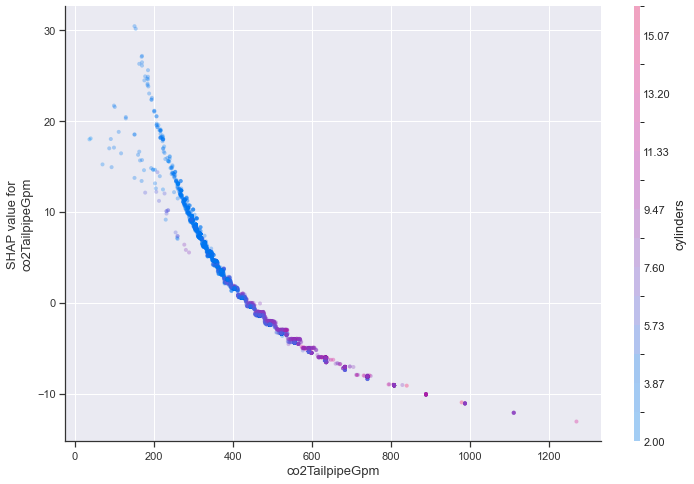

spearman	cylinders→co2TailpipeGpm	corr: 0.784	p-val: 0.0000


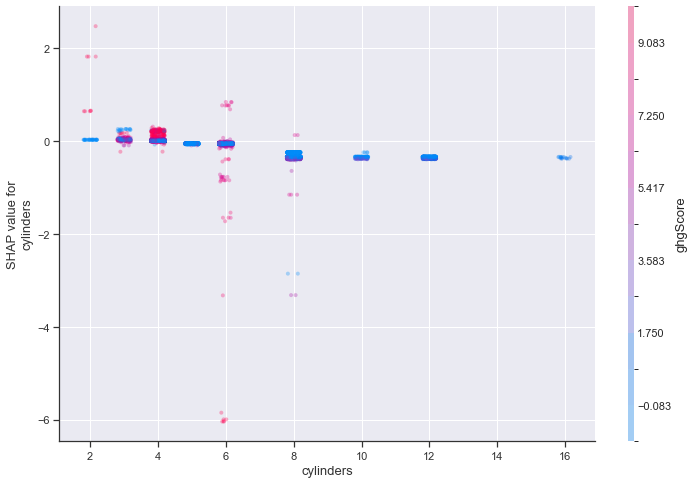

spearman	ghgScore→cylinders		corr: -0.139	p-val: 0.0000


In [126]:
shap.dependence_plot("co2TailpipeGpm", shap_xgb_values_test, X_test,\
                     interaction_index="cylinders", show=False, alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()
print('spearman\tcylinders→co2TailpipeGpm\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.cylinders.values, X_train.co2TailpipeGpm.values)))
shap.dependence_plot("cylinders", shap_xgb_values_train, X_train,
                     interaction_index="ghgScore", show=False,
                     x_jitter=0.4, alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()
print('spearman\tghgScore→cylinders\t\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(top_df.ghgScore.values, top_df.cylinders.values)))

**NB:** <br>
SHAP's plots are a visual representation of what the model has learned from our data. <br>
However, if we have any doubts, we can always go back to the source: the data. <br>
Thus, here we will plot cylinders vers co2TailpipeGpm & the target comb08. <br>
These plots will either confirm our story or tell us something the model is not capturing it. <br>
As we can see below:
- cylinders & co2TailpipeGpm are positively correlated
- cylinders & the target are negatively correlated

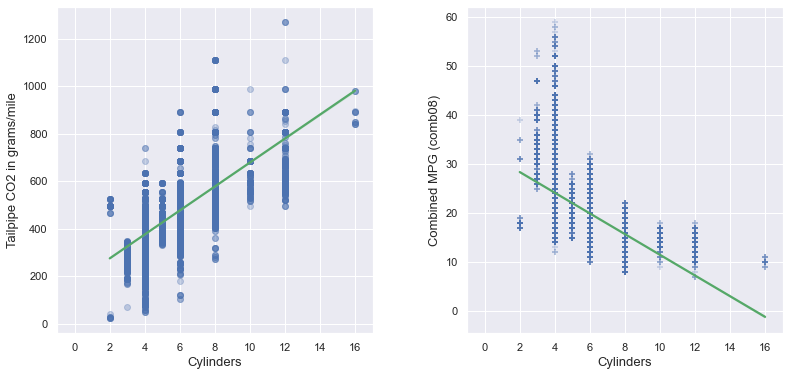

In [129]:
fig, axs = plt.subplots(1, 2, figsize = (13,6))
fig.subplots_adjust(hspace=0, wspace=0.3)
sns.regplot(x=X_train.cylinders, y=X_train.co2TailpipeGpm, ax=axs[0],\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[0].set_ylabel('Tailpipe CO2 in grams/mile', fontsize=13)
axs[0].set_xlabel('Cylinders', fontsize=13)
axs[0].set_xlim([-1,17])
sns.regplot(x=X_train.cylinders, y=y_train, ax=axs[1], marker="+",\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[1].set_ylabel('Combined MPG (comb08)', fontsize=13)
axs[1].set_xlabel('Cylinders', fontsize=13)
axs[1].set_xlim([-1,17])
plt.show() 


### SHAP Force Plots
SHAP force plots help explain locally a model, i.e., one single prediction. <br>
Blie features represent forces pushing the predictions in a negative direction & red ones represent forces pushing the predictions in a positive direction

In [131]:
sample_test_size = 0.01
sample_test_idx = np.random.choice(X_test.shape[0],
                                   math.ceil(X_test.shape[0]*sample_test_size),\
                                   replace=False)
shap.initjs()
shap.force_plot(shap_xgb_explainer.expected_value,\
                shap_xgb_values_test[sample_test_idx],\
                X_test.iloc[sample_test_idx])

## Accumulated Local Effects (ALE) Plots

- to plot simple ALE plots, we will need continuous variables; the fuelType_Diesel vs target ALE plot gives nothing

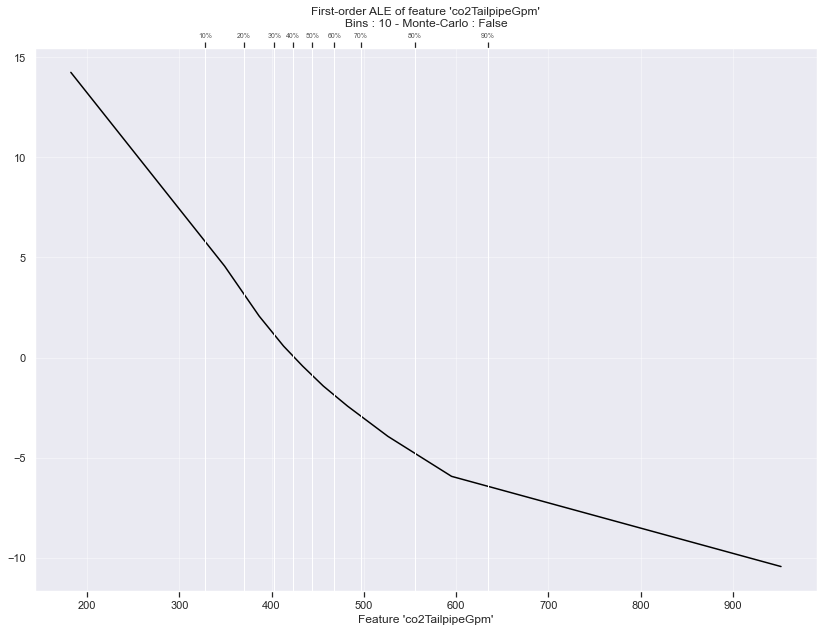

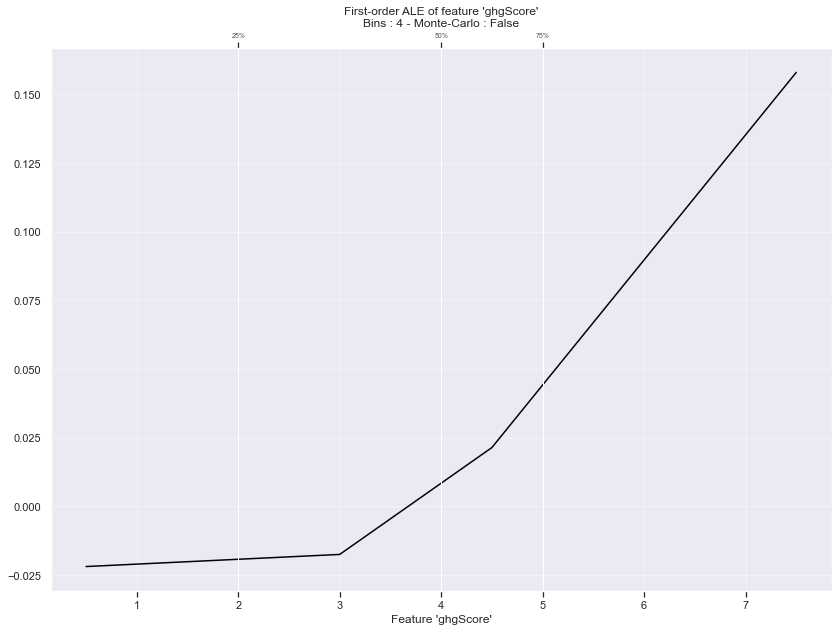

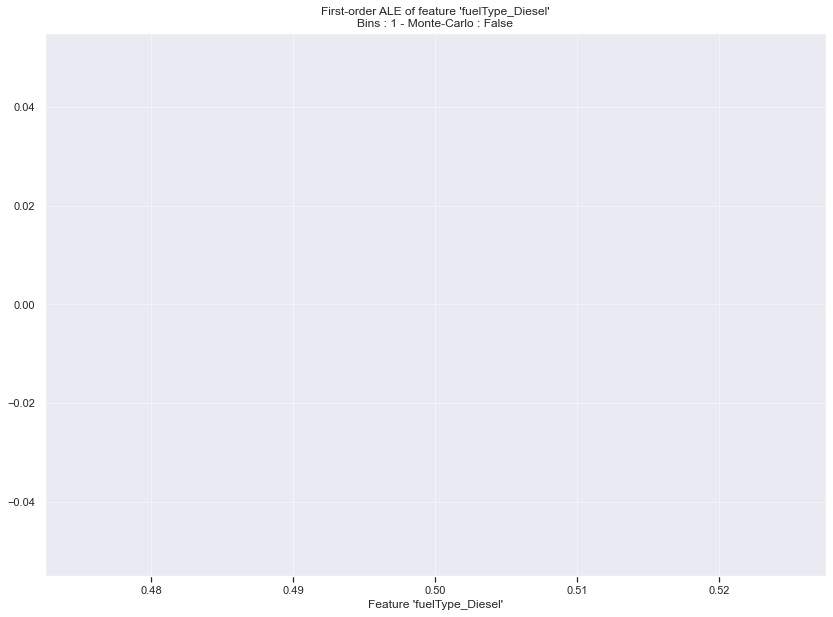

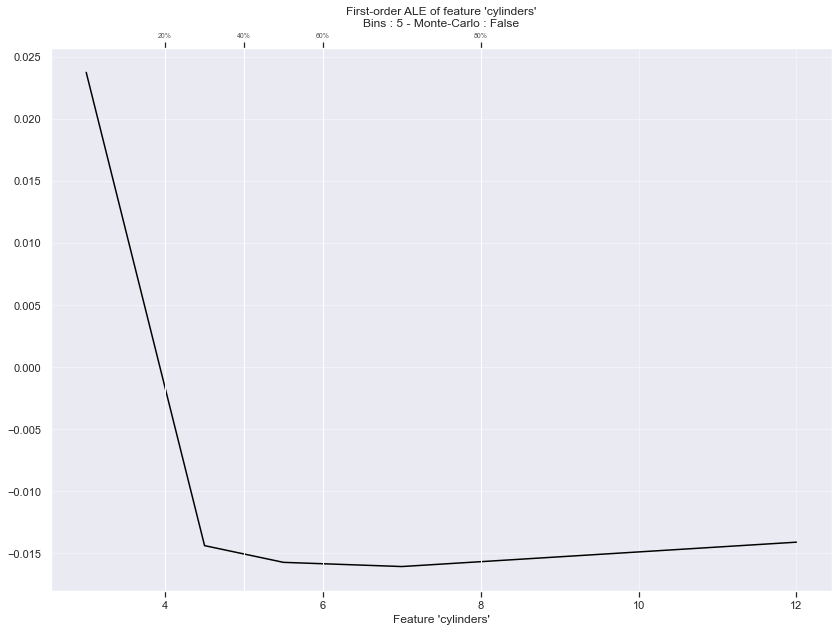

In [134]:
for feature_name in ['co2TailpipeGpm', 'ghgScore', 'fuelType_Diesel', 'cylinders']:
    plt.rc("figure", figsize=(14, 10))
    ale_plot(
        fitted_xgb_model, # the model
        X_test, # the data
        [feature_name], # the feature name
        bins=10, # the number of intervals (quantiles)
#         monte_carlo=True, monte_carlo_rep=50,
#         monte_carlo_ratio=0.4
    )
    plt.show()

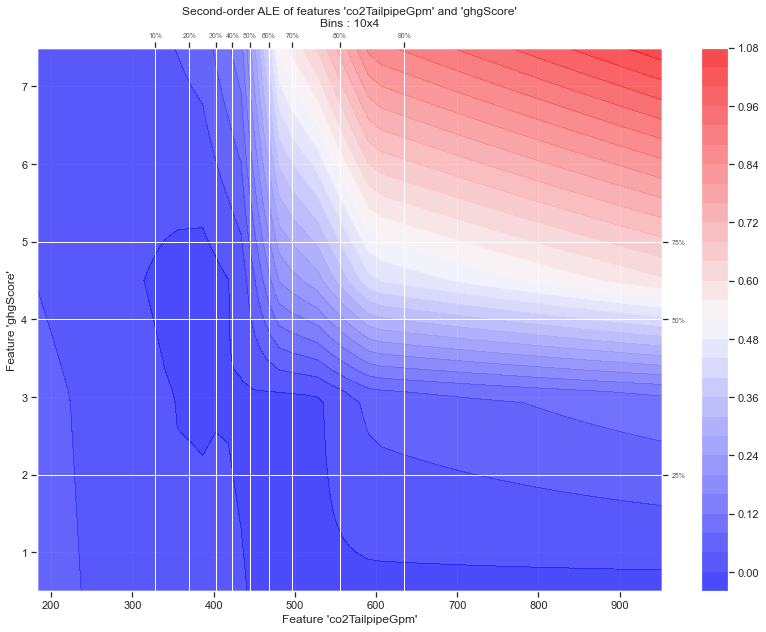

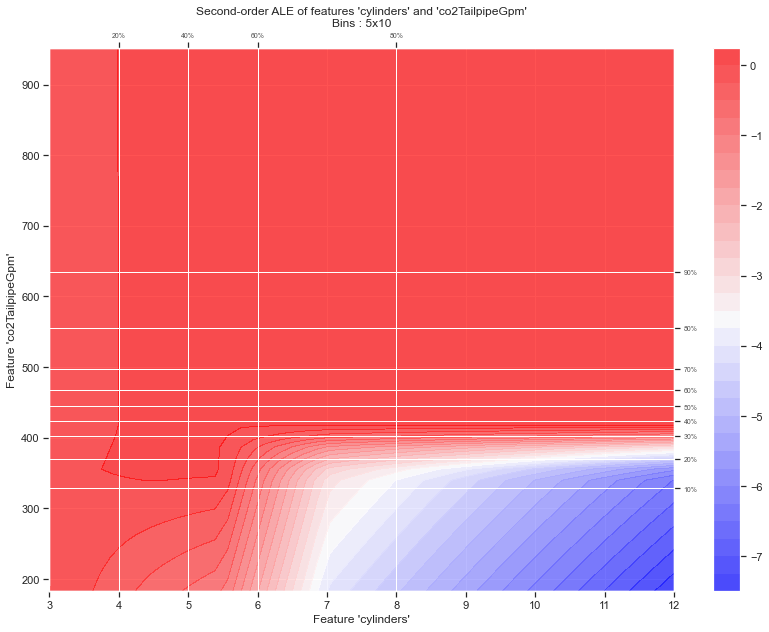

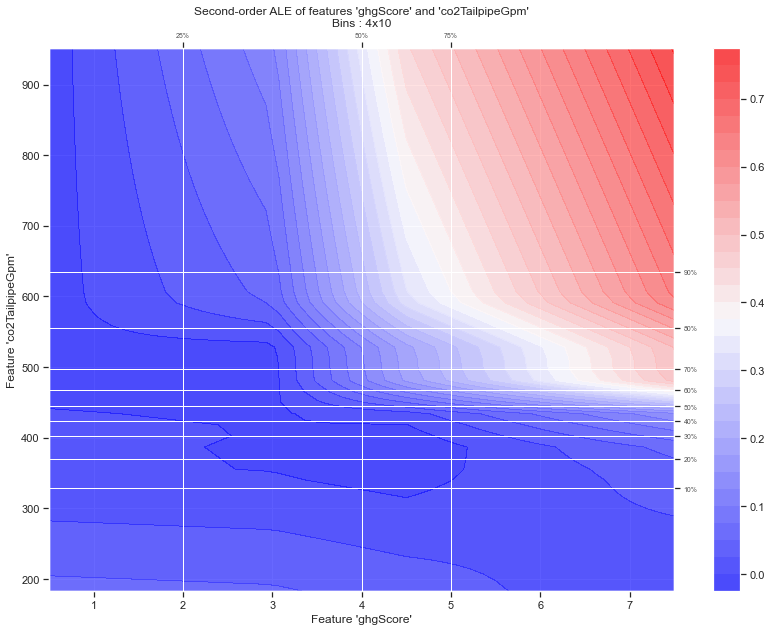

In [138]:
for interaction in [
    ['co2TailpipeGpm', 'ghgScore'],
    ['cylinders', 'co2TailpipeGpm'], 
    ['ghgScore', 'co2TailpipeGpm']]:
    plt.rc("figure", figsize=(14, 10))
    ale_plot(
        fitted_xgb_model, X_test, interaction, bins=[10,10]
    )
    plt.show()

The interaction ALE plots are computed in the same way, but the quantiles now operate in 2 dimensions.
- the interaction ['co2TailpipeGpm', 'ghgScore'] shows negligeable interaction <1 MPG (the right most color coded bar)
- similarly, the interaction ['ghgScore', 'co2TailpipeGpm'] is meaningless
- However, the interaction ['cylinders', 'co2TailpipeGpm'] is high: in fact, for cylinders >=7, and co2TailpipeGpm <400, there is a sizable negative effect on the target

**!!** However, from the SHAP dependence plot previously seen, we have deduced that low co2TailpipeGpm indicate a higher comb08. *From the first SHAP dependence plot: High values of co2TailpipeGpm correlate with lower SHAP values => high co2TailpipeGpm tends to decrease the target i.e., the car being less fuel efficient.* <br>
--> The model here learnt that for these cylinders it must not trust the feature co2TailpipeGpm and penalize the lowest values. <br>
We could assume that there are either data quality issues in the feature co2TailpipeGpm or its formula changes depending on these cylinders